---
title: Nearest Neighbor Model
author: Andrei Akopian
date: 2026-01-17
format:
  html:
    code-fold: true
    code-summary: "Show the code"
  pdf:
    code-overflow: wrap
    echo: false
    output: true
---

Code is a modified version from https://docs.google.com/document/d/1CQh79a8CqsukOWQ1iFNF2xnS6jVw52m86R3_VNKdHJo/edit?tab=t.0

In [4]:
import numpy as np
import pandas as pd
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [5]:
# helper stuff
def open_file(filename):
    path = pathlib.PurePath(filename)
    file_format = path.suffix
    parsing_functions = {
        ".csv" : pd.read_csv,
    }
    return parsing_functions[file_format](filename)

def take_subset(df,start,end):
    """ grab a subset of wavelengths from the dataframe

    return (npv_fractions, spectra, spectra_sources)
    """

    columns = df.columns.to_list()
    wanted = []
    for c in columns:
        if c.isdigit():
            if start<=int(c)<=end:
                wanted.append(c)
    fractions = df[["npv_fraction","gv_fraction","soil_fraction"]]
    spectra = df[wanted]
    spectra_sources = df[["Spectra"]]
    return fractions, spectra, spectra_sources
def simple_histogram(data=[1,2,3],title="Title",x="x-axis",y='y-axis',bins=10):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title)
    ax.hist(data,bins=bins)
    print()

In [6]:
df = open_file('unmixing/original_data.csv')

fractions, nr900to1700, _ = take_subset(df,start=900,end=1700)

In [4]:
fractions

,npv_fraction,gv_fraction,soil_fraction
0,0.840237,0.000000,0.159763
1,0.662722,0.029586,0.307692
2,0.633136,0.035503,0.331361
3,0.349112,0.000000,0.650888
4,0.390533,0.011834,0.597633
...,...,...,...
1718,0.563741,0.436259,0.000000
1719,0.418555,0.581445,0.000000
1720,0.668849,0.331151,0.000000
1721,0.594707,0.405293,0.000000


The k=3 with an R² of 0.7601


npv r^2 0.6626055563484661
gv r^2 0.8343776971172561
soil r^2 0.7833050970487743


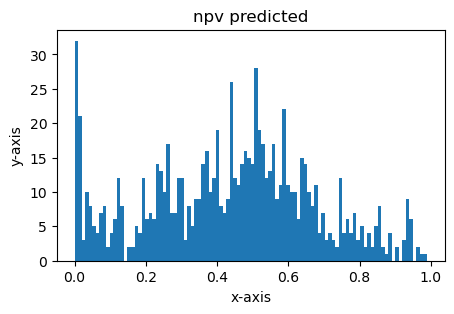

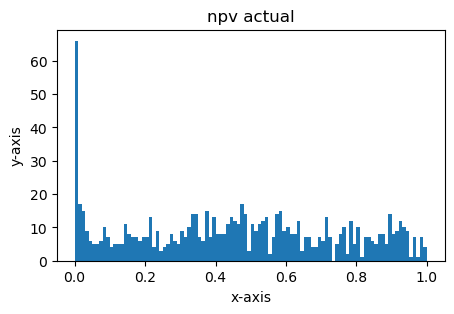

In [11]:
# Normal KNN regression
X_train, X_test, y_train, y_test = train_test_split(nr900to1700, fractions, test_size=0.5, random_state=42)

k=3
knn = KNeighborsRegressor(n_neighbors=3, metric='cosine') # metric defines the distance difinition
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
current_r2 = r2_score(y_test, y_pred)

#print(f"k = {k}, R² Score = {current_r2:.4f}")

print(f"The k={k} with an R² of {current_r2:.4f}")
simple_histogram([y[0] for y in y_pred], title='npv predicted', bins=100)
simple_histogram([y_test.loc[i, 'npv_fraction'] for i in y_test.index], title='npv actual', bins=100)
# simple_histogram([y[1] for y in y_pred], title='gv predicted', bins=100)
# simple_histogram([y[2] for y in y_pred], title='soil predicted', bins=100)
print("npv r^2", r2_score(y_test['npv_fraction'], [p[0] for p in y_pred]))
print("gv r^2", r2_score(y_test['gv_fraction'], [p[1] for p in y_pred]))
print("soil r^2", r2_score(y_test['soil_fraction'], [p[2] for p in y_pred]))

=== Before Reversing Log Transformation ===
Mean Squared Error (MSE): 1.0924
Mean Absolute Error (MAE): 0.5491
R² Score for k=3: 0.8077
npv r^2 0.7432307921662786
gv r^2 0.8019400509481229
soil r^2 0.877971417714592
=== After Reversing Log Transformation ===
Mean Squared Error (MSE): 0.0245
Mean Absolute Error (MAE): 0.0968
R² Score for k=3: 0.7398


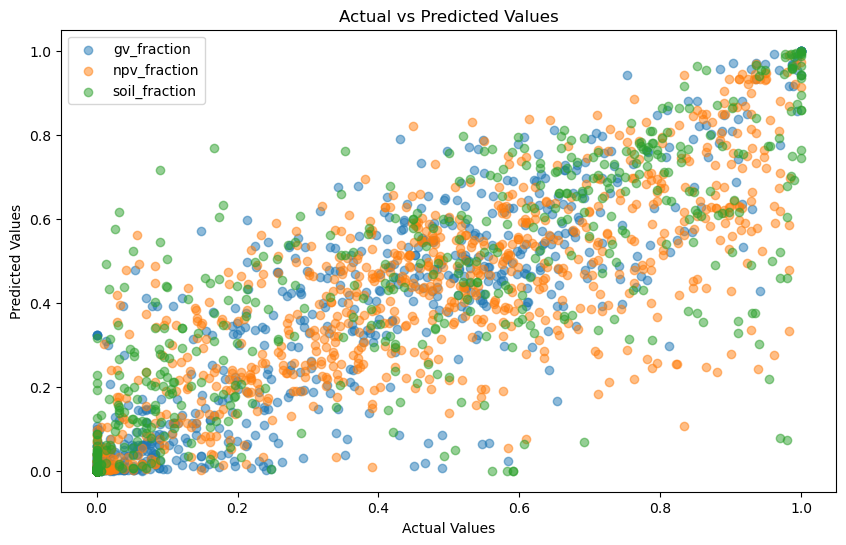

npv_fraction     0.0
gv_fraction      0.0
soil_fraction    0.0
dtype: float64
npv_fraction     1.0
gv_fraction      1.0
soil_fraction    1.0
dtype: float64


In [14]:
# Apply log transformation
fake_fractions = fractions.copy(deep=True)
# soil_space = 950 / fake_fractions.shape[0]
# gv_space = 450 / fake_fractions.shape[0]
# npv_space = 120 / fake_fractions.shape[0]
epsilon = 1/1000 # shift a bit, so zeros aren't zero
base = np.e
base_log = np.log(base)
for i in range(fake_fractions.shape[0]):
    fake_fractions.loc[i] += epsilon
    fake_fractions.loc[i, 'soil_fraction'] = np.log(fake_fractions.loc[i, 'soil_fraction']) / base_log
    fake_fractions.loc[i, 'gv_fraction'] = np.log(fake_fractions.loc[i, 'gv_fraction']) / base_log
    fake_fractions.loc[i, 'npv_fraction'] = np.log(fake_fractions.loc[i, 'npv_fraction']) / base_log

X_train, X_test, y_train, y_test = train_test_split(nr900to1700, fake_fractions, test_size=0.5, random_state=42)
k = 3
knn_best = KNeighborsRegressor(n_neighbors=k, metric='cosine')
knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)

def reverse_transform_frame(data_frame):
    for i in data_frame.index:
        data_frame.loc[i, 'soil_fraction'] = base**data_frame.loc[i, 'soil_fraction']
        data_frame.loc[i, 'gv_fraction'] = base**data_frame.loc[i, 'gv_fraction']
        data_frame.loc[i, 'npv_fraction'] = base**data_frame.loc[i, 'npv_fraction']
        data_frame.loc[i] -= epsilon
    return data_frame

mse = mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)
print("=== Before Reversing Log Transformation ===")
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score for k={k}: {r2:.4f}')
print("npv r^2", r2_score(y_test['npv_fraction'], [p[0] for p in y_pred_best]))
print("gv r^2", r2_score(y_test['gv_fraction'], [p[1] for p in y_pred_best]))
print("soil r^2", r2_score(y_test['soil_fraction'], [p[2] for p in y_pred_best]))

# reverse transformation
y_pred_best = np.pow(base, y_pred_best) - epsilon
y_test = reverse_transform_frame(y_test)

# Calculate regression metrics for the best model
mse = mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

print("=== After Reversing Log Transformation ===")
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score for k={k}: {r2:.4f}')

# Plotting Actual vs Predicted for each target variable
plt.figure(figsize=(10, 6))
plt.scatter(y_test['gv_fraction'], y_pred_best[:, 1], alpha=0.5, label="gv_fraction")
plt.scatter(y_test['npv_fraction'], y_pred_best[:, 0], alpha=0.5, label="npv_fraction")
plt.scatter(y_test['soil_fraction'], y_pred_best[:, 2], alpha=0.5, label="soil_fraction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.title("Actual vs Predicted Values")
plt.show()

#test whether the abundance for npv/gv/soil individually are always between 0 and 1
print(fractions.min())
print(fractions.max())

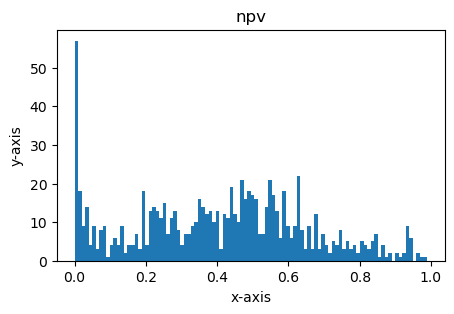

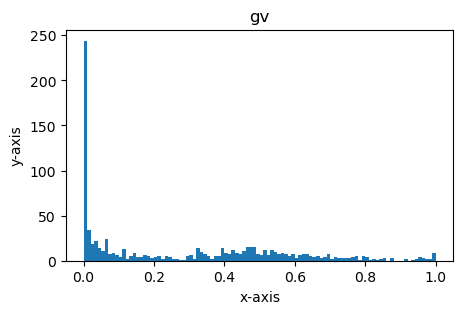

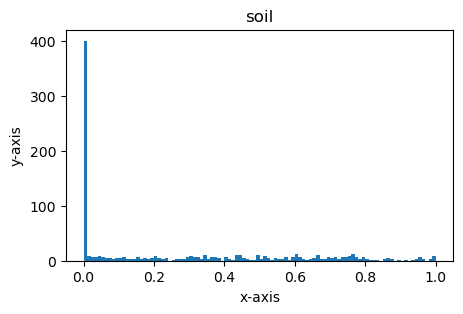

In [14]:
simple_histogram([y[0] for y in y_pred_best], title='npv', bins=100)
simple_histogram([y[1] for y in y_pred_best], title='gv', bins=100)
simple_histogram([y[2] for y in y_pred_best], title='soil', bins=100)

In [19]:
def run_trials(proportion_split, n_trials, k, metric, weights):
    results = [
        [] for i in range(nr900to1700.shape[0])
    ]
    for r_state in [i for i in range(1,n_trials)]:
        X_train, X_test, y_train, y_test = train_test_split(
            nr900to1700,
            fractions,
            test_size=proportion_split,
            # random_state=r_state
        )
        knn = KNeighborsRegressor(
            n_neighbors=k, 
            metric=metric,
            weights=weights,
        )
        knn.fit(X_train, y_train)
        indecies = X_test.index
        predictions = knn.predict(X_test)
        for i, index in enumerate(indecies):
            results[index].append(predictions[i])
    return results
            

In [20]:
proportion = 0.2
trials = 1000
k = 3
metric = 'cosine'
weights = 'uniform'
results = run_trials(proportion_split=0.5, n_trials=1000, k=4,  metric=metric, weights=weights)

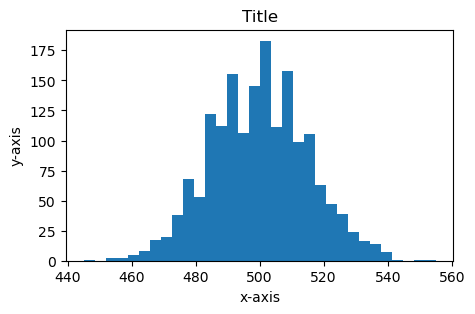

In [22]:
# inspect how many time each point was predicted
simple_histogram([len(r) for r in results], bins='auto')

In [ ]:
metrics = [
    [] for i in range(0, nr900to1700.shape[0])
] # the contents will be lists [npv, gv, soil] where each is a tuple (mean, std, mean_residual)
labels = [
    fractions['npv_fraction'],
    fractions['gv_fraction'],
    fractions['soil_fraction'],
]
for i in range(nr900to1700.shape[0]):
    for j in range(0,3): # npv, gv, soil
        aggregate = [r[j] for r in results[i]]
        mean = np.mean(aggregate)
        metrics[i].append(
            (mean, np.std(aggregate), labels[j][i] - mean) # mean, std, resid
        )

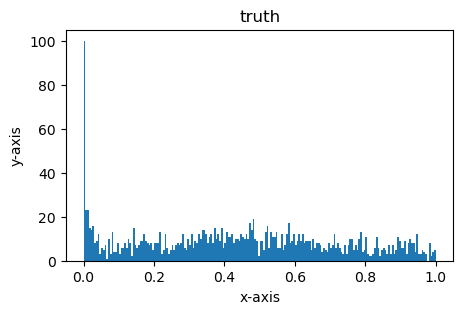

In [8]:
simple_histogram(fractions['npv_fraction'], title='truth', bins=200)

In [26]:
# npv_z_score = [metrics[i][0][2] / metrics[i][0][1] for i in range(nr900to1700.shape[0])]
# gv_z_score = [metrics[i][1][2] / metrics[i][1][1] for i in range(nr900to1700.shape[0])]
# soil_z_score = [metrics[i][2][2] / metrics[i][2][1] for i in range(nr900to1700.shape[0])]
# simple_histogram(np.clip(npv_z_score, a_min=-20, a_max=20), bins=50)
# simple_histogram(np.clip(gv_z_score, a_min=-20, a_max=20), bins=50)
# simple_histogram(np.clip(soil_z_score, a_min=-20, a_max=20), bins=50)

# npv_means = [metrics[i][0][0] for i in range(nr900to1700.shape[0])]
# gv_means = [metrics[i][1][0] for i in range(nr900to1700.shape[0])]
# soil_means = [metrics[i][2][0] for i in range(nr900to1700.shape[0])]
# simple_histogram(np.clip(npv_means, a_min=-20, a_max=20), title="predictions", bins=100)
# simple_histogram(np.clip(gv_means, a_min=-20, a_max=20), bins=100)
# simple_histogram(np.clip(soil_means, a_min=-20, a_max=20), bins=100)

npv_resid = [metrics[i][0][2] for i in range(nr900to1700.shape[0])]
gv_resid = [metrics[i][1][2] for i in range(nr900to1700.shape[0])]
soil_resid = [metrics[i][2][2] for i in range(nr900to1700.shape[0])]

print(f"KNN percentiles. k={k}, test_size={proportion}, n_trials={trials}, metric={metric}, weights={weights}")
print("NPV 5th and 95th percentiles: ", np.percentile(npv_resid, 5), np.percentile(npv_resid, 95))
print("GV 5th and 95th percentiles: ", np.percentile(gv_resid, 5), np.percentile(gv_resid, 95))
print("SOIL 5th and 95th percentiles: ", np.percentile(soil_resid, 5), np.percentile(soil_resid, 95))

KNN percentiles. k=3, test_size=0.2, n_trials=1000, metric=cosine, weights=uniform
NPV 5th and 95th percentiles:  -0.2422630925362965 0.2636276465095409
GV 5th and 95th percentiles:  -0.19153586214607649 0.18849879891000024
SOIL 5th and 95th percentiles:  -0.2385505115457003 0.23072231235980703
